## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1 # max(list(v)) returns the element from the edge with maximum value

#nqubits = 5 # because we have five 'points'
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits) 
    b = [int(b[i]) for i in range(nqubits)] # for x=1 np.binary_repr(1, 5) is [0,0,0,0,1] and we do an int, 
    #for x=2**5-1=31=1+2+4+8+16, np.binary_repr on 5 bits returns [1,1,1,1,1]
    # TODO: Complete the computation below:      
    
    val=0
    for (i,j) in edges:
        val=val+(-b[i]*b[j]) # Sum of val of energy on each edge (i,j)
    
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 1, 1, 1, 1]


#### visualization of the graph

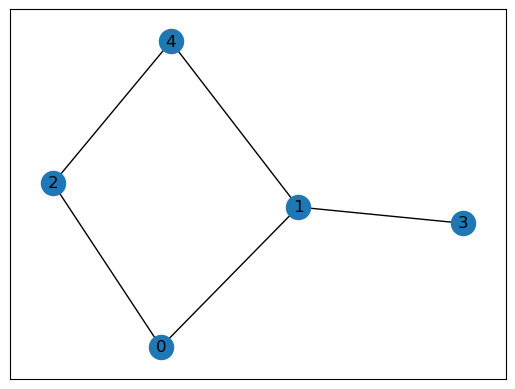

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    
    # step 1: One rotation RX(theta) on each qubit, parameterized by some angle theta common to all qubits
    for i in range (n_qubits):
        layer.apply(RX(theta),i)
    # step 2: A “cost function” layer in which the unitary evolution generated by the cost function Hamiltonian 
    # e−iβHC is applied to the qubits   
    # As we did in TP1, exp(-i*beta*HC) = exp(-i*beta* SUM on i,j∈E of He(i, j)) with He=σiσj, 
    # with the Pauli matrix σz=Z=[[1,0],[0,-1]] that is why we use U_ZZ
    # This is applied on the circuit on each pair of edge with the Trotterization: PROD on i,j∈E of exp(-i*beta*ZZ)
    for (i,j) in edges:
        layer.apply(U_ZZ(beta), i, j)
    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    
    for q in qubits: 
        prog.apply(H,[q]) #initialization
    i,j=0,1
    for k in range (n_layers):
        theta=parameters[i]
        beta=parameters[j]
        one_qaoa_layer(n_qubits, edges, theta, beta) #quantum circuit parametrized 
        i+=2
        j+=2    
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        state_vector=sample.state.bitstring
        #compute the value of the observable on the state vector
        obs+=state_vector #the observable is the cost function in this case
    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.95288631, 0.12676713, 0.2535495 ])

In [8]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question: The number of layers for QAOA is 6 because its curve crosses the red line representing the optimal value.

In [4]:
import matplotlib.pylab as plt
from scipy.optimize import minimize #sometimes the code needs me to rewrite the libraries in order to run 
import numpy as np

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

NameError: name 'evaluate_parameters' is not defined

In [6]:
#we need U_XX definition from TP1
def U_XX(theta):
    
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*theta),0)
    xx_r.apply(CNOT, 0, 1)

    return xx_r

### Question 6: smart initialization

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z
from qat.qpus import get_default_qpu
import matplotlib.pylab as plt
from scipy.optimize import minimize #sometimes the code needs me to rewrite the libraries in order to run 
import numpy as np

T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    
    prog = Program()
    qubits = prog.qalloc(nqubits)
    
    for q in qubits: 
        prog.apply(H,[q]) #first layer of Hadamard
    def one_layer(n_qubits,n_layers, edgess, k):
        layer = QRoutine()
        for (i,j) in edgess:
            layer.apply(U_XX((T/n_layers)*(1-(k/n_layers))), i, j)
            layer.apply(U_ZZ((T/n_layers)*(k/n_layers)),i,j)
        return layer
    for k in range (nlayers):
        one_layer(nqubits,nlayers, edges, k)        
    circ = prog.to_circ()
    job = circ.to_job()
    qpu = get_default_qpu()
    result = qpu.submit(job)
    
    parameters_init = []
    for sample in result:
        parameters_init+=sample #the observable is the cost function in this case
    
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers)) #added
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()